In [35]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
from tqdm import tqdm
from PIL import Image
import requests
import torch
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import CLIPProcessor, CLIPModel
import numpy as np

query_texts = ["一只猫", "一只狗",'两只猫', '两只老虎','一只老虎']  # 这里是输入文本的，可以随意替换。
# 加载Taiyi 中文 text encoder
text_tokenizer = BertTokenizer.from_pretrained("IDEA-CCNL/Taiyi-CLIP-Roberta-102M-Chinese")
text_encoder = BertForSequenceClassification.from_pretrained("IDEA-CCNL/Taiyi-CLIP-Roberta-102M-Chinese").eval()
text = text_tokenizer(query_texts, return_tensors='pt', padding=True)['input_ids']

url = "http://images.cocodataset.org/val2017/000000039769.jpg"  # 这里可以换成任意图片的url
# 加载CLIP的image encoder
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")  
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
image = processor(images=Image.open(requests.get(url, stream=True).raw), return_tensors="pt")

with torch.no_grad():
    image_features = clip_model.get_image_features(**image)
    text_features = text_encoder(text).logits
    # 归一化
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    # 计算余弦相似度 logit_scale是尺度系数
    logit_scale = clip_model.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    print(np.around(probs, 3))

/home/lyz/anaconda3/envs/py311/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[[0.012 0.    0.987 0.001 0.   ]]


In [36]:
import glob
import torch
import pandas as pd

In [37]:
test_candidate_image = pd.read_csv('./dataset/test_candidate_image.csv')
test_candidate_text = pd.read_csv('./dataset/test_candidate_text.csv')

In [38]:
test_candidate_image

,image_name
0,ifw0YVgHhn.jpg
1,kVXwrhgAqq.jpg
2,qEErowgwW9.jpg
3,2vbaoemd18.jpg
4,5oVksSZRwh.jpg
...,...
14995,2FzH7On27M.jpg
14996,jK2wJZMfQE.jpg
14997,p4KN5Ykzai.jpg
14998,I7sC8tTtrB.jpg


In [39]:
test_candidate_text

,idx,text
0,5000,短裤2019新款允儿妈男婴童夏装男宝宝大pp裤婴儿三角
1,5001,Moda秋冬新款舒适休闲风印花睡裤女
2,5002,绨2019夏装新款网纱拼接撞色小清新裙子中长款宽松显瘦
3,5003,日落大道的优雅 常青常新的经典单品 珍珠扣波点半身
4,5004,芙艾迪儿 光泽高级感缎面蕾丝上衣典雅精致夏季
...,...,...
14995,19995,福利款 牛仔蓝半身裙短裙A包臀裙BBQ-
14996,19996,穿谁好看！设计师公司货高端力荐 外贸男装工厂剪标尾货短袖
14997,19997,米拉EMILIA2019新秋款渐变色风衣女XH19GWT-
14998,19998,着暗黑系女装2019年秋装新款潮 休闲宽松慵懒风bf长袖黑色


In [40]:
text_text_features = []
for idx in tqdm(range(len(test_candidate_text['text']) // 100 + 1)):
    batch_text = test_candidate_text['text'].iloc[idx*100:(idx+1)*100].values
    if len(batch_text) == 0:
        continue
    text = text_tokenizer(list(batch_text), return_tensors='pt', padding=True)['input_ids']
    with torch.no_grad():
        text_features = text_encoder(text).logits
        text_features = text_features.data.numpy()
        text_text_features.append(text_features)

100%|██████████| 151/151 [01:52<00:00,  1.34it/s]


In [41]:
text_text_features = np.vstack(text_text_features)

In [42]:
img_img_features = []
for idx in tqdm(range(len(test_candidate_image['image_name']) // 100 + 1)):
    batch_img = test_candidate_image['image_name'].iloc[idx*100:(idx+1)*100].values
    if len(batch_img) == 0:
        continue

    image = processor(images=[Image.open('./dataset/images/' + x) for x in batch_img], return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**image)
        image_features = image_features.data.numpy()
        img_img_features.append(image_features)

100%|██████████| 151/151 [04:32<00:00,  1.81s/it]


In [43]:
img_img_features = np.vstack(img_img_features)

In [44]:
from sklearn.preprocessing import normalize

In [45]:
text_text_features = normalize(text_text_features)
img_img_features = normalize(img_img_features)

In [46]:
text_text_features.shape, img_img_features.shape

((15000, 512), (15000, 512))

In [48]:
ids = np.dot(text_text_features, img_img_features.T)

In [49]:
ids.shape

(15000, 15000)

In [56]:
for idx in range(len(ids)):
    text = test_candidate_text['text'].iloc[idx]
    top1_image = test_candidate_image['image_name'].iloc[ids[idx].argsort()[-1]]
    break

In [57]:
text

'短裤2019新款允儿妈男婴童夏装男宝宝大pp裤婴儿三角'

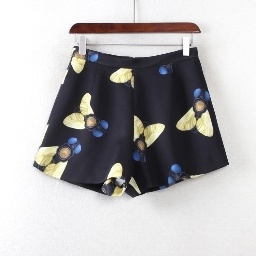

In [70]:
Image.open('./dataset/images/' + top1_image)
# Image.open('./dataset/images/' + 'Ral1W3htIr.jpg')

In [60]:
image_name = []
for idx in range(len(ids)):
    top1_image = test_candidate_image['image_name'].iloc[ids[idx].argsort()[-1]]
    image_name.append(top1_image)

In [61]:
test_candidate_text['image_name'] = image_name

In [64]:
test_candidate_text[['idx', 'image_name']].to_csv('submit.csv', index=None)

In [65]:
import numpy as np
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(1-ids)
col_ind

array([11188,  2997, 13755, ..., 10857,  1087,   176])

In [71]:
test_candidate_text['image_name'] = test_candidate_image['image_name'].iloc[col_ind].values
test_candidate_text[['idx', 'image_name']].to_csv('submit_linear_sum.csv', index=None)